<a href="https://colab.research.google.com/github/afrago/dl-upna-face-recognition/blob/master/dl_upna_Face_Recognition_02_VGGFace2Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Reconocimiento Facial

El reconocimiento facial es la tarea general de identificar y verificar a las personas a partir de fotografías de su rostro.

## Modelos VGGFace y VGGFace2 
VGGFace se refiere a una serie de modelos desarrollados para el reconocimiento de rostros y demostrados en conjuntos de datos de visión computarizada de referencia, desarrollada por miembros del Grupo de Geometría Visual (VGG) de la Universidad de Oxford.

Actualmente hay dos modelos principales de VGG para el reconocimiento facial, el VGGFace y el VGGFace2. 

### Modelo VGGFace 
Este conjunto de datos se utiliza como base para el desarrollo de [CNN](https://developers.google.com/machine-learning/practica/image-classification/convolutional-neural-networks) profundos para tareas de reconocimiento facial como la identificación y verificación de rostros. 
Los modelos se entrenan con un conjunto de datos de gran tamaño, y luego se evalúan en un conjuntos de datos de reconocimiento facial de referencia, demostrando que el modelo es eficaz para generar rasgos generalizados de los rostros.

Estos modelos describen el proceso de entrenamiento de un clasificador de rostros que utiliza una función de [activación de softmax](https://developers.google.com/machine-learning/crash-course/multi-class-neural-networks/softmax?hl=es-419) en la capa de salida para clasificar los rostros como personas.
Posteriormente, esta capa se elimina para que la salida de la red sea una representación vectorial de los rasgos del rostro, llamada incrustación de rostros. 
En la fase final, el modelo se perfecciona, para que la distancia euclidiana entre los vectores generados para una misma identidad sea menor y los vectores generados para diferentes identidades sean mayores. Esto se logra mediante una función de [Perdida de Triplete](https://en.wikipedia.org/wiki/Triplet_loss)

Se utiliza una arquitectura de red neural convolucional profunda al estilo VGG, con bloques de capas convolucionales con pequeños núcleos y [activaciones ReLU](https://developers.google.com/machine-learning/crash-course/glossary?hl=es#unidad-lineal-rectificada-relu,-rectified-linear-unit) seguidas de capas de agrupamiento máximo, y el uso de capas totalmente conectadas en el extremo clasificador de la red.

### VGGFace2 Model
VGGFace2 se ha convertido en el nombre para referirse a los modelos pre-entrenados que proporcionan reconocimiento facial, entrenados con este conjunto de datos.

Los modelos se entrenan en el conjunto de datos, específicamente un modelo [ResNet-50](https://medium.com/@14prakash/understanding-and-implementing-architectures-of-resnet-and-resnext-for-state-of-the-art-image-cf51669e1624) y un modelo SqueezeNet-ResNet-50 (llamado SE-ResNet-50 o SENet), y son variaciones de estos modelos las que han sido puestos a disposición por los autores, junto con el código asociado. Los modelos se evalúan en conjuntos de datos de reconocimiento facial estándar, demostrando así un rendimiento de última generación.





## Instalación de la biblioteca the keras-vggface


In [0]:
! pip install matplotlib
! pip install git+https://github.com/rcmalli/keras-vggface.git


  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-5qw9et4m
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-5qw9et4m
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp36-none-any.whl size=8311 sha256=0f5c4a8a9227a5ced2f2c9d5cdf3b2ac8dc98f6a742b1d135491b624ced923b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-64xquzz0/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface


In [0]:
pip show keras-vggface

Name: keras-vggface
Version: 0.6
Summary: VGGFace implementation with Keras framework
Home-page: https://github.com/rcmalli/keras-vggface
Author: Refik Can MALLI
Author-email: mallir@itu.edu.tr
License: MIT
Location: /usr/local/lib/python3.6/dist-packages
Requires: h5py, keras, numpy, pillow, scipy, six, pyyaml
Required-by: 


In [0]:
import matplotlib.pyplot as pyplot

# check version of keras_vggface
import keras_vggface
# print version
print(keras_vggface.__version__)

Using TensorFlow backend.


0.6


## Etapa 1 y 2: Detección y alineación 

### Cómo detectar rostros para el reconocimiento facial

Antes de que podamos realizar el reconocimiento de rostros, necesitamos detectar los rostros.
La detección de rostros es el proceso de localizar automáticamente los rostros en una fotografía y localizarlos dibujando un cuadro delimitador alrededor de su extensión.

También utilizaremos la Red Neural Convolucional en Cascada Multitarea, o [MTCNN](https://arxiv.org/abs/1604.02878), para la detección de rostros, por ejemplo, encontrar y extraer rostros de las fotos. 
Implementación de [Iván  de Paz Centeno](https://github.com/ipazc/mtcnn)


In [0]:
! pip install mtcnn

     |████████████████████████████████| 2.3MB 2.8MB/s 


In [0]:
from PIL import Image
import numpy as np

# confirm mtcnn was installed correctly
import mtcnn
from mtcnn.mtcnn import MTCNN
# print version
print(mtcnn.__version__)

0.1.0


A continuación, podemos crear una instancia de la clase MTCNN, para la detección de caras todas las caras en la fotografía cargada. Para ello al método detect_faces le trasladamos la lectura de la imágen realizada con el método imread de Matplotlib.


#### Preparando los datos de la imágen

El ejemplo siguiente utiliza la biblioteca PIL (la biblioteca de manejo de imágenes estándar en Python) para cargar una imagen y normalizar sus valores de píxeles.
Los valores de los píxeles suelen ser enteros sin signo en el rango entre 0 y 255. Estos valores pueden ser utilizados directamente en las redes neuronales, pero para acelerar el proceso de modelado se aplica una normalización de los datos.
Esta normalización consiste en escalar los valores de los píxeles en el rango de 0-1 para centrarlos e incluso estandarizar los valores.
Luego podemos usar la biblioteca PIL para redimensionar esta pequeña imagen de la cara al tamaño requerido; específicamente, el modelo espera caras de entrada cuadradas con la forma 224×224.

In [0]:
# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = pyplot.imread(filename)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = np.array(image)
	return face_array

Podemos probar esta función con una fotografía.

Usaremos como ejemplo una fotografía de [Sharon Stone tomada en 2013](https://en.wikipedia.org/wiki/File:Sharon_Stone_Cannes_2013_2.jpg) de Wikipedia publicada bajo una licencia permisiva.

Descarga la fotografía y colócala en el directorio de trabajo actual con el nombre de archivo 'sharon_stone1.jpg'.



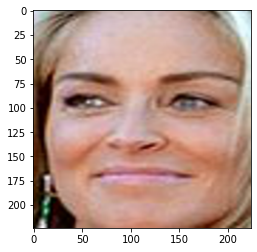

In [0]:
# load the photo and extract the face
pixels = extract_face('sharon_stone1.jpg')
# plot the extracted face
pyplot.imshow(pixels)
# show the plot
pyplot.show()

Al ejecutar el ejemplo se carga la fotografía, se extrae el rostro y se traza el resultado.
Podemos ver que la cara fue detectada y extraída correctamente.

Los resultados sugieren que podemos utilizar la función `extract_face() `desarrollada como base para los ejemplos con el modelo de reconocimiento facial VGGFace que se implementará a continuación.



Podemos probar el modelo con otra celebridad, en este caso, un hombre, Channing Tatum.

Una fotografía de [Channing Tatum tomada en 2017](https://en.wikipedia.org/wiki/File:Channing_Tatum_by_Gage_Skidmore_3.jpg) está disponible en Wikipedia bajo una licencia permisiva.

![Channing Tatum](https://upload.wikimedia.org/wikipedia/commons/thumb/8/8d/Channing_Tatum_by_Gage_Skidmore_3.jpg/456px-Channing_Tatum_by_Gage_Skidmore_3.jpg)


Descarga la fotografía y guárdela en su directorio de trabajo actual con el nombre de archivo 'channing_tatum.jpg'.

## Etapa 3: Representaciones

### Cómo realizar la identificación de la cara con el VGGFace2

Usaremos el modelo VGGFace2 para realizar el reconocimiento facial con fotografías de famosos de Wikipedia.
Un modelo VGGFace puede ser creado usando el constructor VGGFace() y especificando el tipo de modelo a crear mediante el argumento 'model'.

La biblioteca keras-vggface proporciona tres modelos VGGModels pre-entrenados, un modelo VGGFace1 a través de model='vgg16′ (el predeterminado), y dos modelos VGGFace2 'resnet50' y 'senet50'.

El siguiente ejemplo crea un modelo VGGFace2 'resnet50' y resume la forma de las entradas y salidas.

In [0]:
# example of creating a face embedding
from keras_vggface.vggface import VGGFace
# create a vggface2 model
model = VGGFace(model='resnet50')
# summarize input and output shape
print('Inputs: %s' % model.inputs)
print('Outputs: %s' % model.outputs)

165445632/165439116 [==============================] - 12s 0us/step
Inputs: [<tf.Tensor 'input_4:0' shape=(None, 224, 224, 3) dtype=float32>]
Outputs: [<tf.Tensor 'classifier/Softmax:0' shape=(None, 8631) dtype=float32>]


La primera vez que se crea un modelo, la biblioteca descargará los pesos de los modelos y los guardará en el directorio ./keras/models/vggface/ de su directorio personal. El tamaño de los pesos del modelo de resnet50 es de unos 158 megabytes, por lo que la descarga puede tardar unos minutos dependiendo de la velocidad de su conexión a Internet.

Ejecutando el ejemplo se imprime la forma de los tensores de entrada y salida del modelo.

Podemos ver que el modelo espera imágenes en color de entrada de caras con la forma de 244×244 y la salida será una predicción de clase de 8.631 personas. Esto tiene sentido dado que los modelos pre-entrenados fueron entrenados en 8.631 identidades en el conjunto de datos del MS-Celeb-1M (listados en este archivo CSV).

Este modelo de Keras puede ser usado directamente para predecir la probabilidad de que un rostro dado pertenezca a una o más de las más de ocho mil celebridades conocidas; 

Una vez hecha la predicción, los números enteros de la clase se pueden asignar a los nombres de las celebridades, y se pueden recuperar los cinco nombres con mayor probabilidad.

Este comportamiento es proporcionado por la función decode_predictions() en la biblioteca keras-vggface.

Antes de que podamos hacer una predicción con una cara, los valores de los píxeles deben ser escalados de la misma manera en que los datos fueron preparados cuando el modelo VGGFace fue ajustado. Específicamente, los valores de los píxeles deben ser centrados en cada canal usando la media del conjunto de datos de entrenamiento.

Esto puede lograrse utilizando la función preprocess_input() proporcionada en la biblioteca keras-vggface y especificando la 'versión=2' para que las imágenes se escalen utilizando los valores medios usados para entrenar los modelos VGGFace2 en lugar de los modelos VGGFace1 (el valor por defecto).

Podemos unir todo esto y predecir la identidad de nuestra fotografía de Shannon Stone descargada en la sección anterior, específicamente 'sharon_stone1.jpg'.


In [0]:
from numpy import expand_dims
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input
from keras_vggface.utils import decode_predictions

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = pyplot.imread(filename)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# load the photo and extract the face
pixels = extract_face('sharon_stone1.jpg')
# convert one face into samples
pixels = pixels.astype('float32')
samples = expand_dims(pixels, axis=0)
# prepare the face for the model, e.g. center pixels
samples = preprocess_input(samples, version=2 )
# create a vggface model
model = VGGFace(model='resnet50')
# perform prediction
m_prediction = model.predict(samples)
# convert prediction into names
results = decode_predictions(m_prediction)
# display most likely results
for result in results[0]:
	print('%s: %.3f%%' % (result[0], result[1]*100))

1351680/1346516 [==============================] - 1s 1us/step
b' Sharon_Stone': 99.479%
b' Noelle_Reno': 0.060%
b' Emma_Atkins': 0.037%
b' Line_Verndal': 0.024%
b' Anita_Lipnicka': 0.021%


Al ejecutar el ejemplo se carga la fotografía, se extrae el único rostro que sabemos que estaba presente, y luego se predice la identidad del rostro.

Entonces se muestran los cinco nombres de mayor probabilidad.

Podemos ver que el modelo identifica correctamente la cara como perteneciente a Sharon Stone con una probabilidad del 99%.

## Etapa 4: Verificación

Se puede utilizar un modelo VGGFace2 para la verificación de la cara.

Esto implica calcular una incrustación de la cara para una nueva cara dada y comparar la incrustación con la incrustación para el único ejemplo de la cara conocida por el sistema.

Una incrustación facial es un vector que representa los rasgos extraídos de la cara. Esto puede entonces compararse con los vectores generados para otras caras. Por ejemplo, otro vector que está cerca (en cierta medida) puede ser la misma persona, mientras que otro vector que está lejos (en cierta medida) puede ser una persona diferente.

Las medidas típicas como la distancia euclidiana y la distancia coseno se calculan entre dos incrustaciones y se dice que las caras coinciden o verifican si la distancia está por debajo de un umbral predefinido, a menudo ajustado para un conjunto de datos o aplicación específicos.

En primer lugar, podemos cargar el modelo VGGFace sin el clasificador estableciendo el argumento 'include_top' en 'False', especificando la forma de la salida a través de la 'input_shape' y estableciendo 'pooling' en 'avg' para que los mapas de filtro en el extremo de salida del modelo se reduzcan a un vector utilizando el promedio global de pooling.

Este modelo puede utilizarse entonces para hacer una predicción, que devolverá una incrustación de caras para una o más caras proporcionadas como entrada.

Podemos definir una nueva función que, dada una lista de nombres de archivo para las fotos que contienen una cara, extraerá una cara de cada foto mediante la función extract_face() desarrollada en una sección anterior, se requiere un preprocesamiento para las entradas al modelo VGGFace2 y puede lograrse llamando a preprocess_input(), y luego predecir una incrustación de una cara para cada una.

La función get_embeddings() que se muestra a continuación implementa esto, devolviendo una matriz que contiene una incrustación para una cara para cada nombre de archivo de fotografía proporcionado.

### Cómo realizar la verificación de la cara con el VGGFace2
Podemos tomar nuestra fotografía de Sharon Stone utilizada anteriormente (por ejemplo, sharon_stone1.jpg) como nuestra definición de la identidad de Sharon Stone calculando y almacenando la incrustación de la cara para la cara en esa fotografía.

Podemos entonces calcular las incrustaciones para los rostros en otras fotografías de Sharon Stone y probar si podemos verificar efectivamente su identidad. También podemos utilizar rostros de fotografías de otras personas para confirmar que no están verificadas como Sharon Stone.

La verificación puede realizarse calculando la distancia del coseno entre la incrustación de la identidad conocida y las incrustaciones de los rostros candidatos. Esto puede lograrse usando la función coseno() SciPy. La distancia máxima entre dos incrustaciones es de 1,0, mientras que la distancia mínima es de 0,0. Un valor de corte común utilizado para la identidad de las caras es entre 0,4 y 0,6, como 0,5, aunque esto debe ajustarse para una aplicación.

La función is_match() que se muestra a continuación implementa esto, calculando la distancia entre dos incrustaciones e interpretando el resultado.

Podemos probar algunos ejemplos positivos descargando más fotos de Sharon Stone de Wikipedia.

Específicamente, una fotografía [tomada en 2002](https://en.wikipedia.org/wiki/File:Sharon_Stone..jpg) (descargar y guardar como 'sharon_stone2.jpg'), y una fotografía [tomada en 2017](https://en.wikipedia.org/wiki/File:Sharon_Stone_by_Gage_Skidmore_3.jpg) (descargar y guardar como 'sharon_stone3.jpg')

* [sharon_stone2.jpg](https://en.wikipedia.org/wiki/File:Sharon_Stone..jpg)
* [sharon_stone3.jpg](https://en.wikipedia.org/wiki/File:Sharon_Stone_by_Gage_Skidmore_3.jpg)

Analizaremos estos dos casos positivos y la foto de Channing Tatum de la sección anterior como un ejemplo negativo.

In [0]:
from matplotlib import pyplot
from PIL import Image
from numpy import asarray
from scipy.spatial.distance import cosine
from mtcnn.mtcnn import MTCNN
from keras_vggface.vggface import VGGFace
from keras_vggface.utils import preprocess_input

# extract a single face from a given photograph
def extract_face(filename, required_size=(224, 224)):
	# load image from file
	pixels = pyplot.imread(filename)
	# create the detector, using default weights
	detector = MTCNN()
	# detect faces in the image
	results = detector.detect_faces(pixels)
	# extract the bounding box from the first face
	x1, y1, width, height = results[0]['box']
	x2, y2 = x1 + width, y1 + height
	# extract the face
	face = pixels[y1:y2, x1:x2]
	# resize pixels to the model size
	image = Image.fromarray(face)
	image = image.resize(required_size)
	face_array = asarray(image)
	return face_array

# extract faces and calculate face embeddings for a list of photo files
def get_embeddings(filenames):
	# extract faces
	faces = [extract_face(f) for f in filenames]
	# convert into an array of samples
	samples = asarray(faces, 'float32')
	# prepare the face for the model, e.g. center pixels
	samples = preprocess_input(samples, version=2)
	# create a vggface model
	model = VGGFace(model='resnet50', include_top=False, input_shape=(224, 224, 3), pooling='avg')
	# perform prediction
	yhat = model.predict(samples)
	return yhat

# determine if a candidate face is a match for a known face
def is_match(known_embedding, candidate_embedding, thresh=0.5):
	# calculate distance between embeddings
	score = cosine(known_embedding, candidate_embedding)
	if score <= thresh:
		print('>face is a Match (%.3f <= %.3f)' % (score, thresh))
	else:
		print('>face is NOT a Match (%.3f > %.3f)' % (score, thresh))

# define filenames
filenames = ['sharon_stone1.jpg', 'sharon_stone2.jpg',
	'sharon_stone3.jpg', 'channing_tatum.jpg']
# get embeddings file filenames
embeddings = get_embeddings(filenames)
# define sharon stone
sharon_id = embeddings[0]
# verify known photos of sharon
print('Positive Tests')
is_match(embeddings[0], embeddings[1])
is_match(embeddings[0], embeddings[2])
# verify known photos of other people
print('Negative Tests')
is_match(embeddings[0], embeddings[3])

94699520/94694792 [==============================] - 7s 0us/step
Positive Tests
>face is a Match (0.474 <= 0.500)
>face is a Match (0.313 <= 0.500)
Negative Tests
>face is NOT a Match (0.729 > 0.500)


## Bibliografía

Brownlee, J. (2019), _Image Classification, Object Detection in Python_. Machine Learning Mastery. Recuperado de [aquí](https://machinelearningmastery.com/)